In [1]:
# start to let c_EC affect j_SEI - start from solvent diffusion limited
# how?  
# 1. change: elif self.options["SEI"] == "solvent-diffusion limited": in sei_growth.py
# 2. change: self.C_sei_solvent in lithium_ion_parameters.py
# 3. now have long term cycling 

In [2]:
import pybamm as pybamm;import pandas as pd   ;import numpy as np;import os;import matplotlib.pyplot as plt;import os; #import imageio
from scipy.io import savemat,loadmat;from pybamm import constants,exp;import matplotlib as mpl; fs=17; # or we can set import matplotlib.pyplot as plt then say 'mpl.rc...'
for k in range(0,1):
    mpl.rcParams["axes.labelsize"] = fs
    mpl.rcParams["axes.titlesize"] = fs
    mpl.rcParams["xtick.labelsize"] =  fs
    mpl.rcParams["ytick.labelsize"] =  fs
    mpl.rcParams["legend.fontsize"] =  fs
    mpl.rcParams['font.sans-serif'] = ['Times New Roman']
    mpl.rcParams['font.serif'] = ['Times New Roman']
    mpl.rcParams['axes.unicode_minus'] = False

In [3]:
V_max = 4.2;        V_min = 2.5;
Diff_SEI = 1.700000000000002e-20;    R_SEI = 2E5;   Bulk_Sol_Con = 4541.0;
Experiment_Long   = pybamm.Experiment( [ (
    f"Discharge at 1 C until {V_min} V", 
    f"Charge at 0.3 C until {V_max} V", 
    f"Hold at {V_max} V until C/5")    ] * 1000 )  
save_at_cycles= 100

In [4]:
Model_0 = pybamm.lithium_ion.DFN(     
    options={
        "SEI":"solvent-diffusion limited",          
        "SEI film resistance":"distributed",          
        "SEI porosity change":"true",               
        "solvent diffusion": "EC"     } )
Model_1 = pybamm.lithium_ion.DFN(     
    options={      
        "SEI":"solvent-diffusion limited",          
        "SEI film resistance":"distributed",          
        "SEI porosity change":"true",   
        "solvent diffusion": "none"     } )
ChemistryChen=pybamm.parameter_sets.Chen2020 
ChemistryChen["electrolyte"] = "lipf6_Nyman2008_rio";
Para_0=pybamm.ParameterValues(chemistry=ChemistryChen);

Para_0.update({'EC transference number':-1.4})
Para_0.update({'EC Lithium ion cross diffusivity [m2.s-1]':1.5e-9/1e2})
Para_0.update({'Typical EC Lithium ion cross diffusivity [m2.s-1]':1.5e-9/1e2})
Para_0.update({'EC diffusivity in electrolyte [m2.s-1]':3E-10})
Para_0.update({'Electrolyte diffusivity [m2.s-1]':3e-10})
Para_0.update({'Outer SEI solvent diffusivity [m2.s-1]':1.7e-20})


Confirm: using solvent-diffusion limited
have you come here?
Confirm: using solvent-diffusion limited


Para_0.search("diffusivity")
gamma_e_ec_Rio = Para_0.evaluate(Model_0.param.gamma_e_ec_Rio)  
print(gamma_e_ec_Rio)

In [5]:

def t_plus_tanh( c_e,c_EC, T  ):
    ratio = c_EC / c_e
    coff = 0.3
    return coff/2 + coff/2 *  pybamm.tanh((ratio-2.7705)*2)
Para_0.update({'Cation transference number':t_plus_tanh})

In [13]:
Para_0['Cation transference number']

<function __main__.t_plus_tanh(c_e, c_EC, T)>

In [6]:
Sim_2    = pybamm.Simulation(
    Model_1, experiment = Experiment_Long,
    parameter_values = Para_0,
    solver = pybamm.CasadiSolver(),)       
Sol_2    = Sim_2.solve(save_at_cycles=save_at_cycles,);

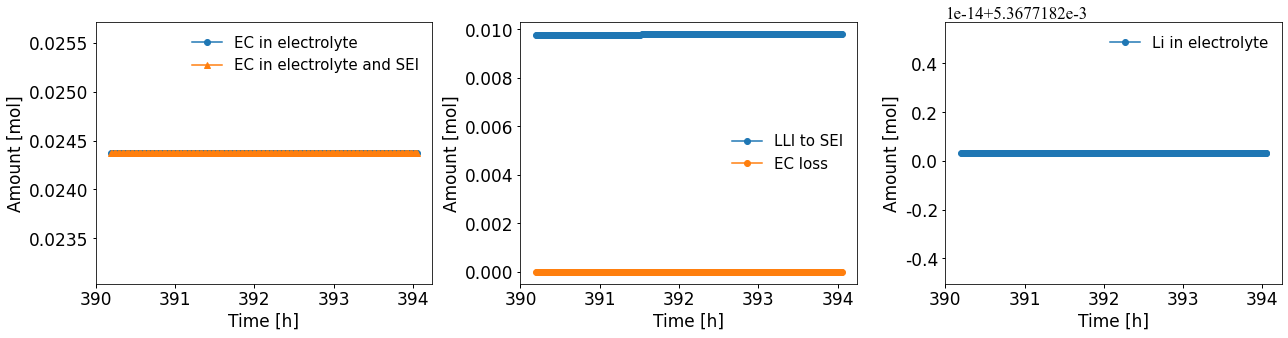

In [11]:
index = 99
Li_eley = Sol_2.cycles[index]["Total lithium in electrolyte [mol]"].entries
EC_eley = Sol_2.cycles[index]["Total EC in electrolyte [mol]"].entries
EC_eleySEI = Sol_2.cycles[index]["Total EC in electrolyte and SEI [mol]"].entries
t = Sol_2.cycles[index]["Time [h]"].entries - Sol_2["Time [h]"].entries[0]
LLI_SEI = Sol_2.cycles[index]["Loss of lithium to SEI [mol]"].entries

fig, axs = plt.subplots(1,3, figsize=(18,4.8),tight_layout=True)
axs[0].plot(t, EC_eley,'-o',label="EC in electrolyte")
axs[0].plot(t, EC_eleySEI,'-^',label="EC in electrolyte and SEI"  )
axs[1].plot(t, LLI_SEI,'-o',label="LLI to SEI" )
axs[1].plot(t, EC_eley[0]-EC_eley,'-o',label="EC loss" )
axs[2].plot(t, Li_eley,'-o',label="Li in electrolyte" )
for i in range(0,3):
    axs[i].set_xlabel("Time [h]",   fontdict={'family':'DejaVu Sans','size':fs})
    axs[i].set_ylabel("Amount [mol]",   fontdict={'family':'DejaVu Sans','size':fs})
    
    labels = axs[i].get_xticklabels() + axs[i].get_yticklabels(); [label.set_fontname('DejaVu Sans') for label in labels]
    axs[i].tick_params(labelcolor='k', labelsize=fs, width=1) ;  del labels;
    axs[i].legend(prop={'family':'DejaVu Sans','size':fs-2},loc='best',frameon=False)    


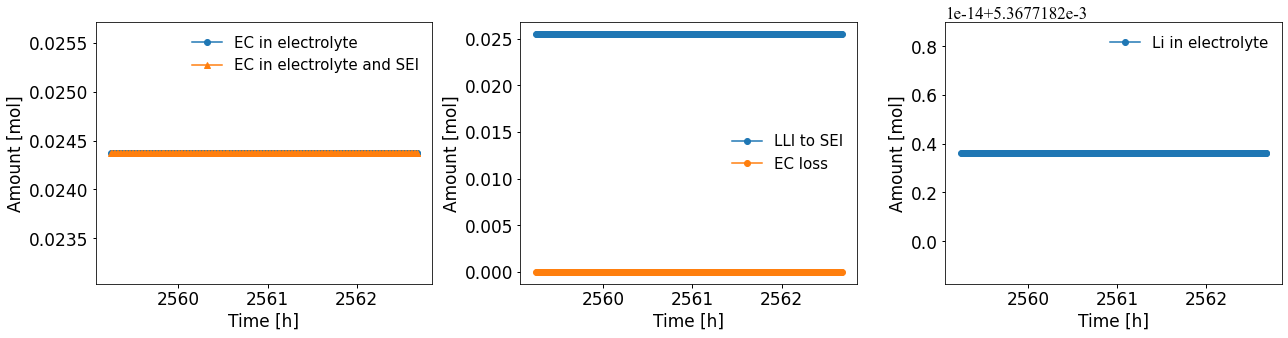

In [12]:
index = 699
Li_eley = Sol_2.cycles[index]["Total lithium in electrolyte [mol]"].entries
EC_eley = Sol_2.cycles[index]["Total EC in electrolyte [mol]"].entries
EC_eleySEI = Sol_2.cycles[index]["Total EC in electrolyte and SEI [mol]"].entries
t = Sol_2.cycles[index]["Time [h]"].entries - Sol_2["Time [h]"].entries[0]
LLI_SEI = Sol_2.cycles[index]["Loss of lithium to SEI [mol]"].entries

fig, axs = plt.subplots(1,3, figsize=(18,4.8),tight_layout=True)
axs[0].plot(t, EC_eley,'-o',label="EC in electrolyte")
axs[0].plot(t, EC_eleySEI,'-^',label="EC in electrolyte and SEI"  )
axs[1].plot(t, LLI_SEI,'-o',label="LLI to SEI" )
axs[1].plot(t, EC_eley[0]-EC_eley,'-o',label="EC loss" )
axs[2].plot(t, Li_eley,'-o',label="Li in electrolyte" )
for i in range(0,3):
    axs[i].set_xlabel("Time [h]",   fontdict={'family':'DejaVu Sans','size':fs})
    axs[i].set_ylabel("Amount [mol]",   fontdict={'family':'DejaVu Sans','size':fs})
    
    labels = axs[i].get_xticklabels() + axs[i].get_yticklabels(); [label.set_fontname('DejaVu Sans') for label in labels]
    axs[i].tick_params(labelcolor='k', labelsize=fs, width=1) ;  del labels;
    axs[i].legend(prop={'family':'DejaVu Sans','size':fs-2},loc='best',frameon=False)    


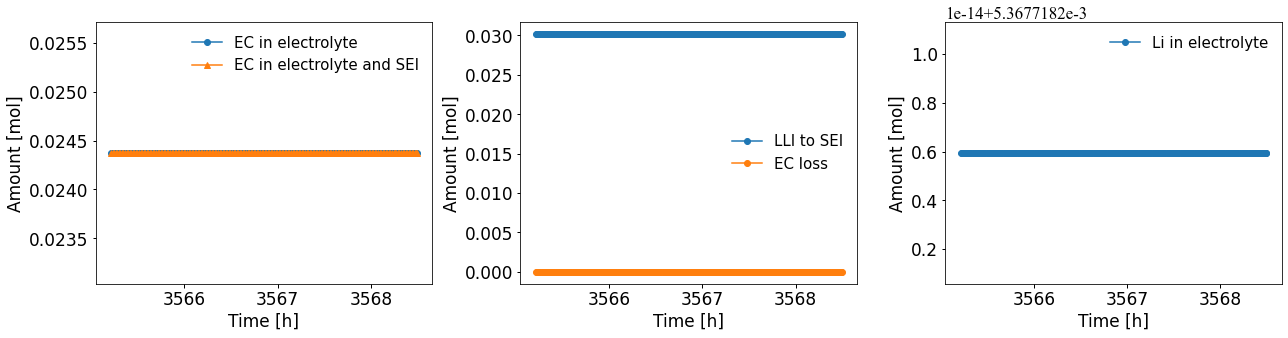

In [10]:
index = 999
Li_eley = Sol_2.cycles[index]["Total lithium in electrolyte [mol]"].entries
EC_eley = Sol_2.cycles[index]["Total EC in electrolyte [mol]"].entries
EC_eleySEI = Sol_2.cycles[index]["Total EC in electrolyte and SEI [mol]"].entries
t = Sol_2.cycles[index]["Time [h]"].entries - Sol_2["Time [h]"].entries[0]
LLI_SEI = Sol_2.cycles[index]["Loss of lithium to SEI [mol]"].entries

fig, axs = plt.subplots(1,3, figsize=(18,4.8),tight_layout=True)
axs[0].plot(t, EC_eley,'-o',label="EC in electrolyte")
axs[0].plot(t, EC_eleySEI,'-^',label="EC in electrolyte and SEI"  )
axs[1].plot(t, LLI_SEI,'-o',label="LLI to SEI" )
axs[1].plot(t, EC_eley[0]-EC_eley,'-o',label="EC loss" )
axs[2].plot(t, Li_eley,'-o',label="Li in electrolyte" )
for i in range(0,3):
    axs[i].set_xlabel("Time [h]",   fontdict={'family':'DejaVu Sans','size':fs})
    axs[i].set_ylabel("Amount [mol]",   fontdict={'family':'DejaVu Sans','size':fs})
    
    labels = axs[i].get_xticklabels() + axs[i].get_yticklabels(); [label.set_fontname('DejaVu Sans') for label in labels]
    axs[i].tick_params(labelcolor='k', labelsize=fs, width=1) ;  del labels;
    axs[i].legend(prop={'family':'DejaVu Sans','size':fs-2},loc='best',frameon=False)    


In [15]:
Sim_0    = pybamm.Simulation(
    Model_0, experiment = Experiment_Long,
    parameter_values = Para_0,
    solver = pybamm.CasadiSolver(),)       
Sol_0    = Sim_0.solve(save_at_cycles=save_at_cycles,);
""" Sim_1    = pybamm.Simulation(
    Model_1, experiment = Experiment_Long,
    parameter_values = Para_0,
    solver = pybamm.CasadiSolver(),)       
Sol_1    = Sim_1.solve(save_at_cycles=save_at_cycles,); """

' Sim_1    = pybamm.Simulation(\n    Model_1, experiment = Experiment_Long,\n    parameter_values = Para_0,\n    solver = pybamm.CasadiSolver(),)       \nSol_1    = Sim_1.solve(save_at_cycles=save_at_cycles,); '

In [ ]:
Model_0.variables.search('loss of')

Loss of active material in negative electrode [%]
Loss of active material in positive electrode [%]
Loss of capacity to SEI [A.h]
Loss of capacity to SEI on cracks [A.h]
Loss of capacity to lithium plating [A.h]
Loss of lithium inventory [%]
Loss of lithium inventory, including electrolyte [%]
Loss of lithium to SEI [mol]
Loss of lithium to SEI on cracks [mol]
Loss of lithium to lithium plating [mol]


In [ ]:
print(Sol_0.cycles[-1]["EC concentration [mol.m-3]"].entries[:,-1])
print(Sol_0.cycles[0]["EC concentration [mol.m-3]"].entries[:,-1])

[ 240.23312898  238.96091797  236.41523966  232.59358586  227.49222125
  221.10622155  213.42952617  204.45500726  194.17455688  182.57919522
  169.65920305  155.40428269  139.80375279  122.84678399  104.52268447
   84.82124714   63.73317399   41.25059785   17.36772836   -7.918342
  -21.73556606  -22.68127735  -23.62696899  -24.57263936  -25.51828682
  -26.46390974  -27.40950649  -28.35507542  -29.30061492  -30.24612334
  -31.19159905  -32.13704041  -33.08244581  -34.02781359  -34.97314214
  -35.91842981  -36.86367498  -37.808876    -38.75403126  -39.69913911
  -45.1187489   -54.53955824  -63.4807703   -71.93673839  -79.90244298
  -87.37351568  -94.34625945 -100.81766482 -106.78542245 -112.24793194
 -117.20430703 -121.6543773  -125.59868629 -129.03848605 -131.97572818
 -134.41305127 -136.35376457 -137.80182802 -138.76182839 -139.23895169]
[3208.83519039 3207.86144747 3205.91343016 3202.99008499 3199.08986408
 3194.21076742 3188.35040037 3181.50604775 3173.6747658  3164.85349392
 3155.0

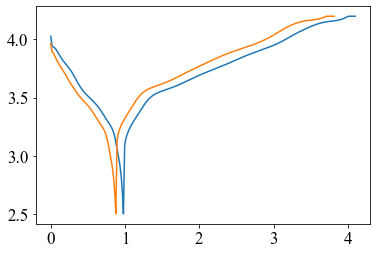

In [ ]:
time_1st = Sol_0.cycles[0]["Time [h]"].entries-Sol_0.cycles[0]["Time [h]"].entries[0]
time_1000th = Sol_0.cycles[-1]["Time [h]"].entries-Sol_0.cycles[-1]["Time [h]"].entries[0]
cap_1st = Sol_0.cycles[0]["Discharge capacity [A.h]"].entries-Sol_0.cycles[0]["Discharge capacity [A.h]"].entries[0]
cap_1000th = Sol_0.cycles[-1]["Discharge capacity [A.h]"].entries-Sol_0.cycles[-1]["Discharge capacity [A.h]"].entries[0]
vol_1st = Sol_0.cycles[0]["Terminal voltage [V]"].entries
vol_1000th = Sol_0.cycles[-1]["Terminal voltage [V]"].entries



plt.plot(time_1st,vol_1st)
plt.plot(time_1000th,vol_1000th)

In [14]:
label = ["1000th cycle"] 
output_variables3 = [
    "Terminal voltage [V]",   
    "EC concentration [mol.m-3]",
    "Electrolyte concentration [mol.m-3]",
    "Total EC in electrolyte [mol]",
    #"Total lithium in electrolyte [mol]",
    "Loss of capacity to SEI [A.h]",
    "Discharge capacity [A.h]",
    "Negative electrode porosity",
    "SEI interfacial current density",
]
quick_plot = pybamm.QuickPlot([Sol_2.cycles[999]], output_variables3,label,) #     variable_limits='tight'
quick_plot.dynamic_plot();

interactive(children=(FloatSlider(value=3565.211408640277, description='t', max=3568.4916944136103, min=3565.2…

In [ ]:
label = ["SEI + double diffusion","SEI + single diffusion",] 
output_variables3 = [
    "Terminal voltage [V]",   
    "EC concentration [mol.m-3]",
    "Electrolyte concentration [mol.m-3]",
    "Total EC in electrolyte [mol]",
    #"Total lithium in electrolyte [mol]",
    "Loss of capacity to SEI [A.h]",
    #"Discharge capacity [A.h]",
    "Total EC in electrolyte and SEI [mol]",
]
quick_plot = pybamm.QuickPlot([Sol_0,Sol_1], output_variables3,label,) #     variable_limits='tight'
quick_plot.dynamic_plot();

interactive(children=(FloatSlider(value=0.0, description='t', max=76.28450366357507, step=0.7628450366357507),…

In [ ]:
label = ["SEI + double diffusion","SEI + single diffusion",] 
output_variables3 = [
    #"Terminal voltage [V]",   
    "Negative electrode SEI interfacial current density [A.m-2]",
]
quick_plot = pybamm.QuickPlot([Sol_0,Sol_1], output_variables3,label,) #     variable_limits='tight'
quick_plot.dynamic_plot();

interactive(children=(FloatSlider(value=0.0, description='t', max=76.28450366357507, step=0.7628450366357507),…